In [ ]:
import sys
print("Python version:", sys.version)

Python version: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


$$
\dfrac{\partial p}{\partial t} = -v_{max}p (1-2\dfrac{p}{p_{max}})\dfrac{\partial p}{\partial x}
$$

In [ ]:
class Domain1D:
    def __init__(self, step, min_val=-1, max_val=1):
        from numpy import linspace
        self.step = step
        n = int((max_val - min_val) / step) + 1
        self.vals = linspace(min_val, max_val, n)

    def __len__(self): # length in terms of # of grid points
        return len(self.vals)

    def __getitem__(self, I): # values by an arbitrary Numpy index-slice `I`
        return self.vals[I]

In [ ]:
T = Domain1D(0.1, min_val=0.0, max_val=120.0)
X = Domain1D(0.01, min_val=-5.0, max_val=5.0)
X

In [ ]:
class Solution1D: # P and X
    def __init__(self, T, X, p0=None):
        from numpy import zeros
        assert isinstance(T, Domain1D) and isinstance(X, Domain1D)
        self.T = T
        self.X = X
        self.p_max = 160
        self.v_max = 120/60/60

        self.vals = zeros((len(T), len(X) + 2)) # ghost cells

        if p0 is not None and len(T) > 0:
            self.vals[0, 1:-1] = p0(X) if callable(p0) else p0
            self.update_ghosts(0)

    def __getitem__(self, s): # values by arbitrary Numpy-style slice
        assert isinstance(s, tuple) and len(s) == 2
        J, I = s[0], s[1]
        return self.vals[J, I]

    def __setitem__(self, s, x):
        assert isinstance(s, tuple) and len(s) == 2
        J, I = s[0], s[1]
        self.vals[J, I] = x

    def __len__(self):
        return len(self.T)

    def update_ghosts(self, j): # periodic boundaries
        self.vals[j+1, 0] = self.vals[j, -2]
        self.vals[j+1, -1] = self.vals[j, 1]

In [ ]:
def plot_grid(P, J=None
              , figsize=(16, 8), markersize=4, linewidth=1
              , title_str=None, axes=True
             ):
    assert isinstance(P, Solution1D)

    from matplotlib.pyplot import figure, gca, plot, legend, show
    fig = figure(figsize=figsize)
    ax = gca()

    for c, j in enumerate(J):
        ax.plot(P.X, P[j, 1:-1], 'o-', color=f'C{c}', label=f't={P.T[j]}'
                , markersize=markersize, linewidth=linewidth)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\approx p(x,t)$', rotation=0, horizontalalignment='right')
    if title_str is not None:
        ax.set_title(title_str, loc='left')
    if axes:
        ax.axhline(0, color='grey', linewidth=0.5, linestyle='dashed')
        ax.axvline(0, color='grey', linewidth=0.5, linestyle='dashed')
    legend()
    show()

In [ ]:
def impulse(X, x0=0.0, w=0.25):
    assert isinstance(X, Domain1D)
    from numpy import ones
    p0 = ones(len(X))*80
    I = (x0-w <= X.vals) & (X.vals <= x0)
    p0[I] = 160
    I = (X.vals > x0)
    p0[I] = 0
    return p0

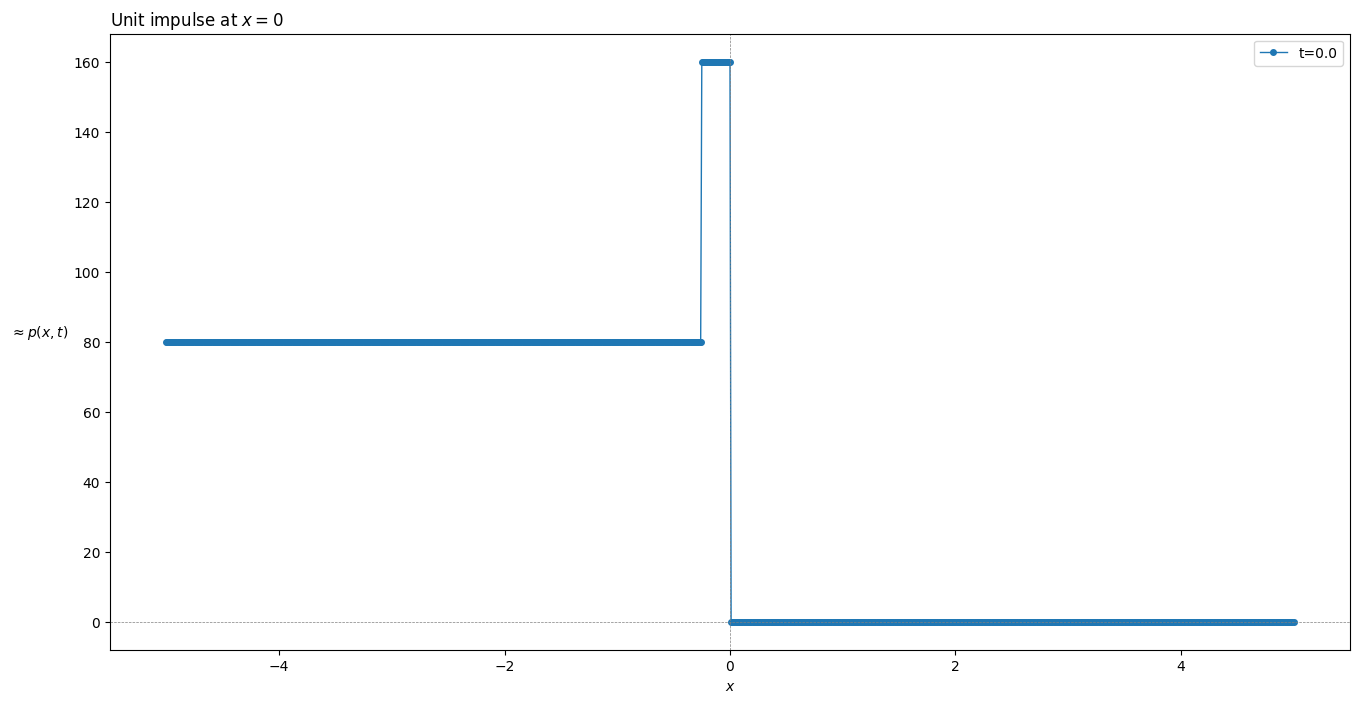

In [ ]:
# Demo:
P_impulse = Solution1D(T, X, p0=impulse)
plot_grid(P_impulse,J=[0], title_str=r'Unit impulse at $x=0$')

In [ ]:
def contour(P, figsize=(18, 4), markersize=4):
    from matplotlib.pyplot import subplot
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure, gca, plot, legend, show
    fig = figure(figsize=figsize)

    Xm,Tm = np.meshgrid(X, T)
    fig, ax = plt.subplots(1, 3 , figsize=(15, 3.5))
    cp=ax[0].contourf(Xm,Tm,P[:,1:-1])
    fig.colorbar(cp)
    F = P.v_max*(1 - P[:, 1:-1]/P.p_max)*P[:,1:-1]
    cp=ax[1].contourf(Xm,Tm,F)
    fig.colorbar(cp)
    V = P.v_max*(1 - P[:, 1:-1]/P.p_max)
    cp=ax[2].contourf(Xm,Tm,V)
    fig.colorbar(cp)
    ax[0].set_title('P over X and T')
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('T')
    ax[1].set_title('F over X and T')
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('T')
    ax[2].set_title('V over X and T')
    ax[2].set_xlabel('X')
    ax[2].set_ylabel('T')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    show()

In [ ]:
def simulate(P, stepper): # modifies `U` in-place
    for j in range(len(T)-1):
        stepper(P, j)
        P.update_ghosts(j)


$$
p_{i,j+1}= p_{i,j} -\dfrac{h}{s}v_{max} ((1-\dfrac{p_{i+1,j}}{p_{max}})p_{i+1,j}-(1-\dfrac{p_{i,j}}{p_{max}})p_{i,j})
$$

In [ ]:
def step_upwind(P, j):
    import numpy as np
    h, s = P.T.step, P.X.step
    p_max = P.p_max
    v_max = P.v_max
    # Extract the relevant portions of P
    P1 = np.clip(P[j, 1:-1], 0, p_max)
    P2 = np.clip(P[j, 2:], 0, p_max)

    # Calculate the new values of P
    P_new = P1 - (h / s * v_max) * ((1 - P2 / p_max) * P2 - (1 - P1 / p_max) * P1)

    # Update the values of P in place
    P[j+1, 1:-1] = np.clip(P_new, 0, p_max)

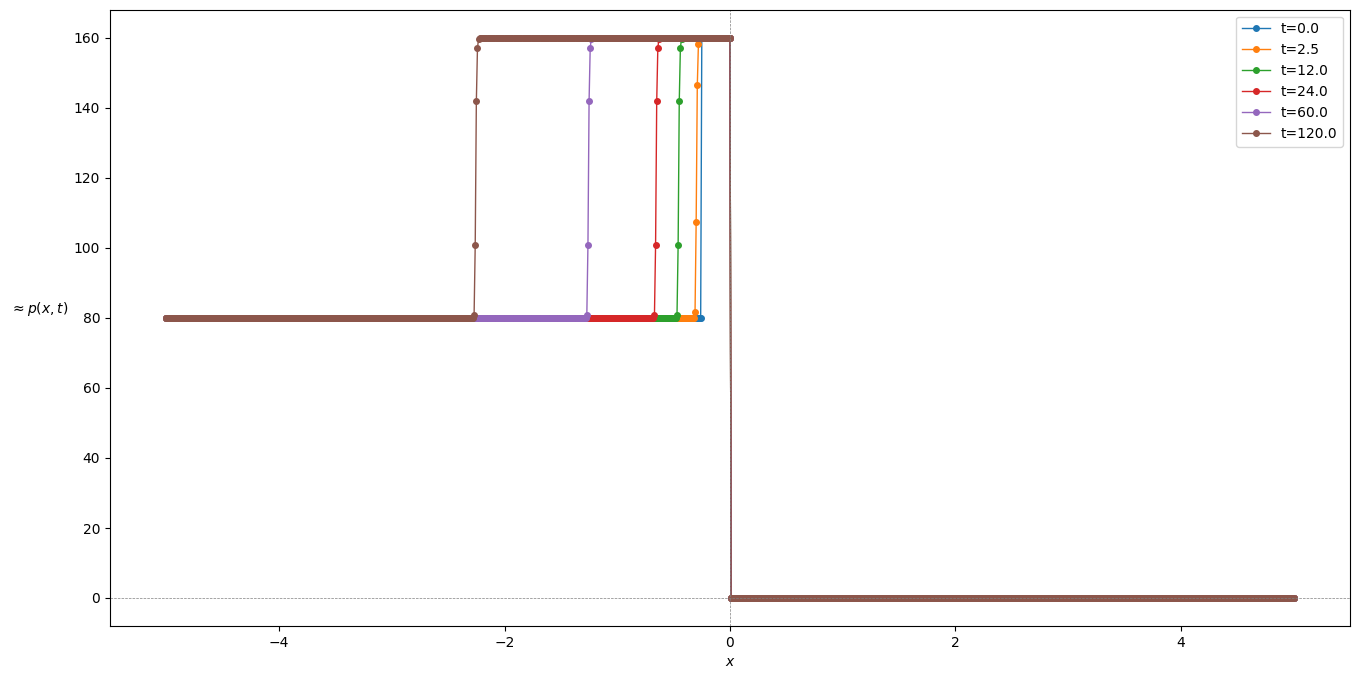

In [ ]:
# step_upwind with different time steps:
P_upwind = Solution1D(T, X, p0=impulse)
simulate(P_upwind, lambda P, j: step_upwind(P, j))
plot_grid(P_upwind, J=[0 ,25,120, 240, 600, 1200])

<Figure size 1800x400 with 0 Axes>

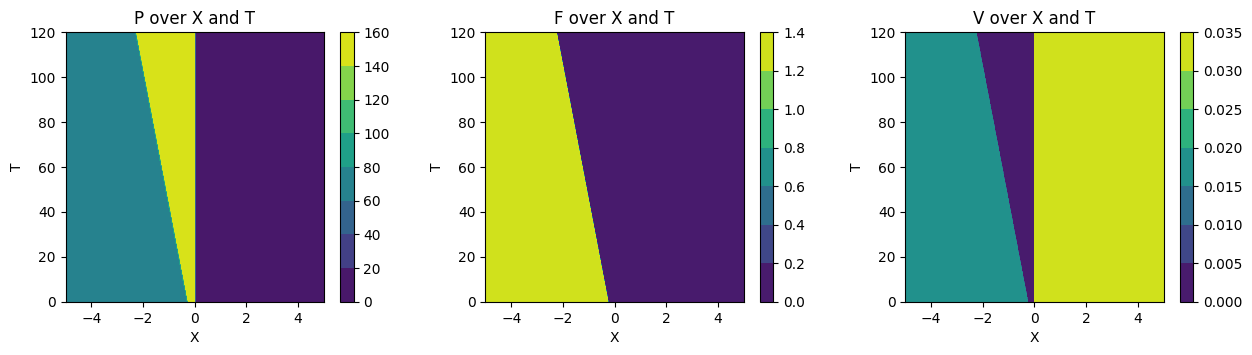

In [ ]:
contour(P_upwind)

$$
p_{i,j+1}= \dfrac{p_{i+1,j} + p_{i-1,j}}{2}-\dfrac{h}{s} \dfrac{f_{i+1,j} - f_{i-1,j}}{2}
$$

In [ ]:
def step_laxf(P, j):
    import numpy as np
    h, s = P.T.step, P.X.step
    P1 = np.clip(P[j, 2:], 0, 1e6)
    P2 = np.clip(P[j, :-2], 0, 1e6)
    F1 = P.v_max*(1 - P[j, 2:]/P.p_max)*P[j, 2:]
    F2 = P.v_max*(1 - P[j, :-2]/P.p_max)*P[j, :-2]

    P_new = (P1 + P2)/2 - h/s*(F1-F2)/2
    P[j+1, 1:-1] = np.clip(P_new, 0, 1e6)

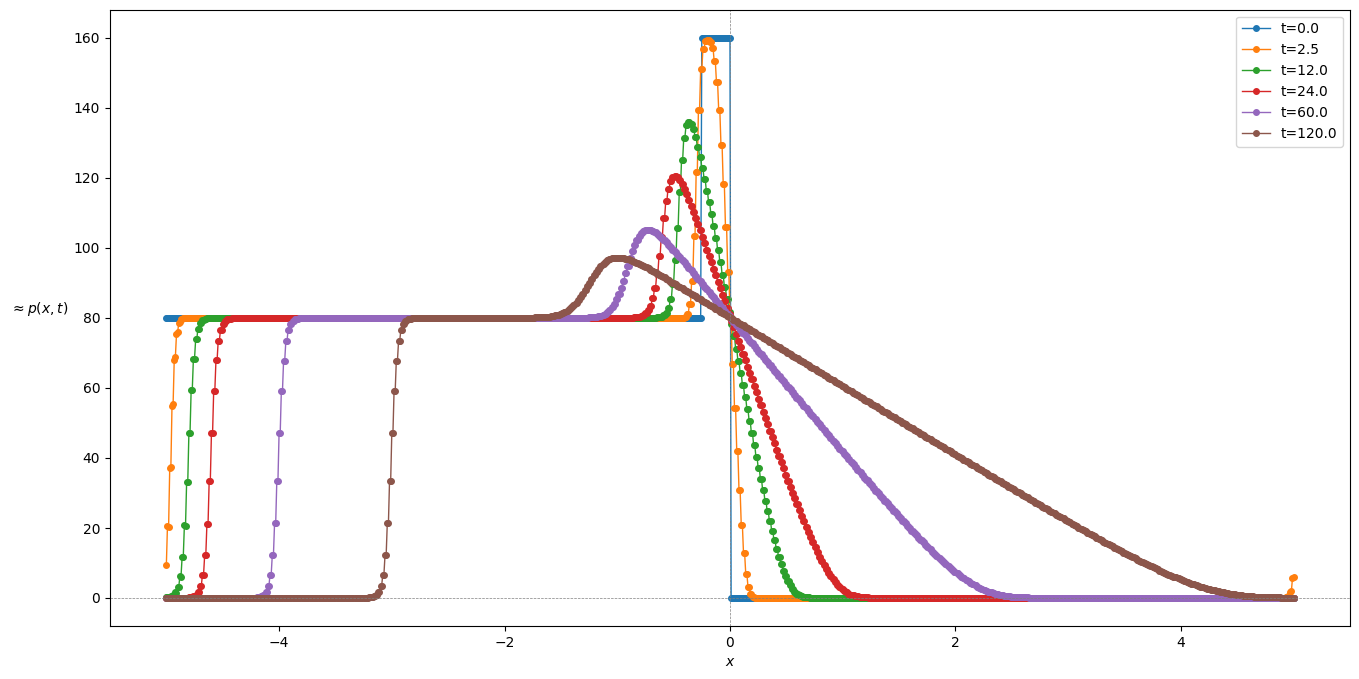

In [ ]:
# Lax-Friedrichs with different time steps:
P_laxf = Solution1D(T, X, p0=impulse)
simulate(P_laxf, lambda P, j: step_laxf(P, j))
plot_grid(P_laxf, J=[0 ,25,120, 240, 600, 1200])

<Figure size 1800x400 with 0 Axes>

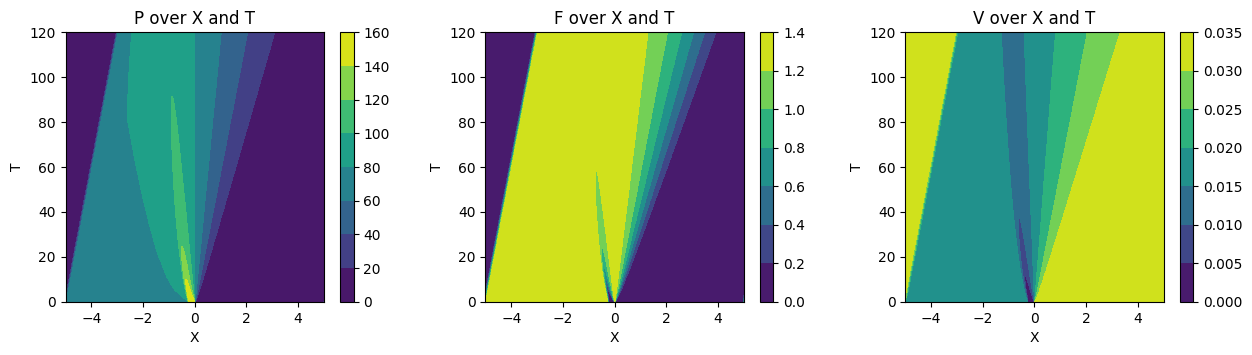

In [ ]:
contour(P_laxf)

In [ ]:
class SolutionCA:
    def __init__(self, T, X, V, c0=None):
        from numpy import zeros
        assert isinstance(T, Domain1D) and isinstance(X, Domain1D)
        self.T = T
        self.X = X
        self.V = V
        self.vals = zeros((len(T), len(X) + V*2)) # ghost cells

        if c0 is not None and len(T) > 0:
            self.vals[0, V:-V] = c0(X) if callable(c0) else c0
            self.update_ghosts(0)

    def __getitem__(self, s): # values by arbitrary Numpy-style slice
        assert isinstance(s, tuple) and len(s) == 2
        J, I = s[0], s[1]
        return self.vals[J, I]

    def __setitem__(self, s, x):
        assert isinstance(s, tuple) and len(s) == 2
        J, I = s[0], s[1]
        self.vals[J, I] = x

    def __len__(self):
        return len(self.T)

    def update_ghosts(self, j): # periodic boundaries
        for v in range(self.V):
          self.vals[j+1, v] = self.vals[j, v- self.V]

In [ ]:
import matplotlib.pyplot as plt
def show_grid(grid, vertical=True, **args):
    plt.matshow(grid, cmap ='binary')
    plt.ylabel('time, $t$', rotation=0, horizontalalignment='right')
    plt.xlabel('position, $x$')

In [ ]:
def impulseCA(X):
    assert isinstance(X, Domain1D)
    import numpy as np
    c0 = np.zeros(len(X))
    initial_density = 0.1
    num_cars = int(len(X) * initial_density)
    car_positions = np.random.choice(len(X), num_cars, replace=False)
    for car_idx in car_positions:
        c0[car_idx] = np.random.randint(1,6)
    return c0

In [ ]:
def CA_algorithm(C,j):
    V_max = C.V
    front_car = len(C[0,:])
    front_car_v=0
    for x in reversed(range(len(C[0,:-V]))):
        v = C[j, x]
        if 1 <= v:
            distance = int(front_car - x -1)
            next_pos = int(x+v-1)
            # Rule 1: Accelerate
            if v <= distance:
                C[j+1, next_pos] = min(v + 1, V_max) # Rule 3 :Move
            # Rule 2 :Decelerate
            else:
                next_pos = int(x + distance) # Rule 3 :Move
                C[j+1, next_pos] = distance
            front_car = x
            front_car_v = v


In [ ]:
#steps and V_max can be modified
T = Domain1D(1, min_val=0.0, max_val=120.0)
X = Domain1D(0.0075, min_val=-5.0, max_val=5.0)
V = 5

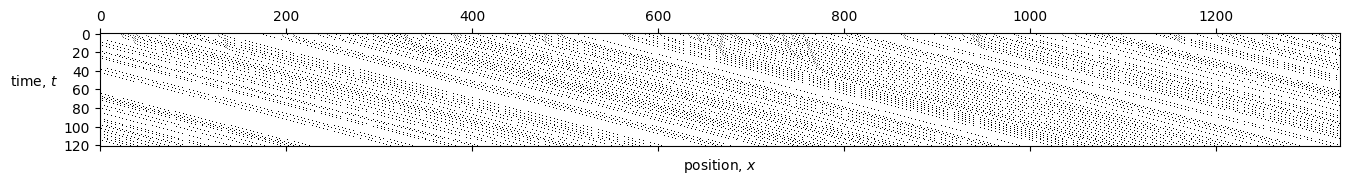

In [ ]:
# randomly generating the inital cars
C = SolutionCA(T, X, V, c0=impulseCA)
simulate(C, lambda C, j: CA_algorithm(C, j))
show_grid(C[:,V:-V])
